In [222]:
import pandas as pd
import matplotlib.pyplot as plt

ddir = "universe_8/"
data = pd.read_csv(ddir + 'combined_stars.csv')

Name, X_stars, Y_stars, rad_velocity, parallax = data["Name"] , data["X"], data["Y"], data["RadialVelocity"], data["Parallax"]


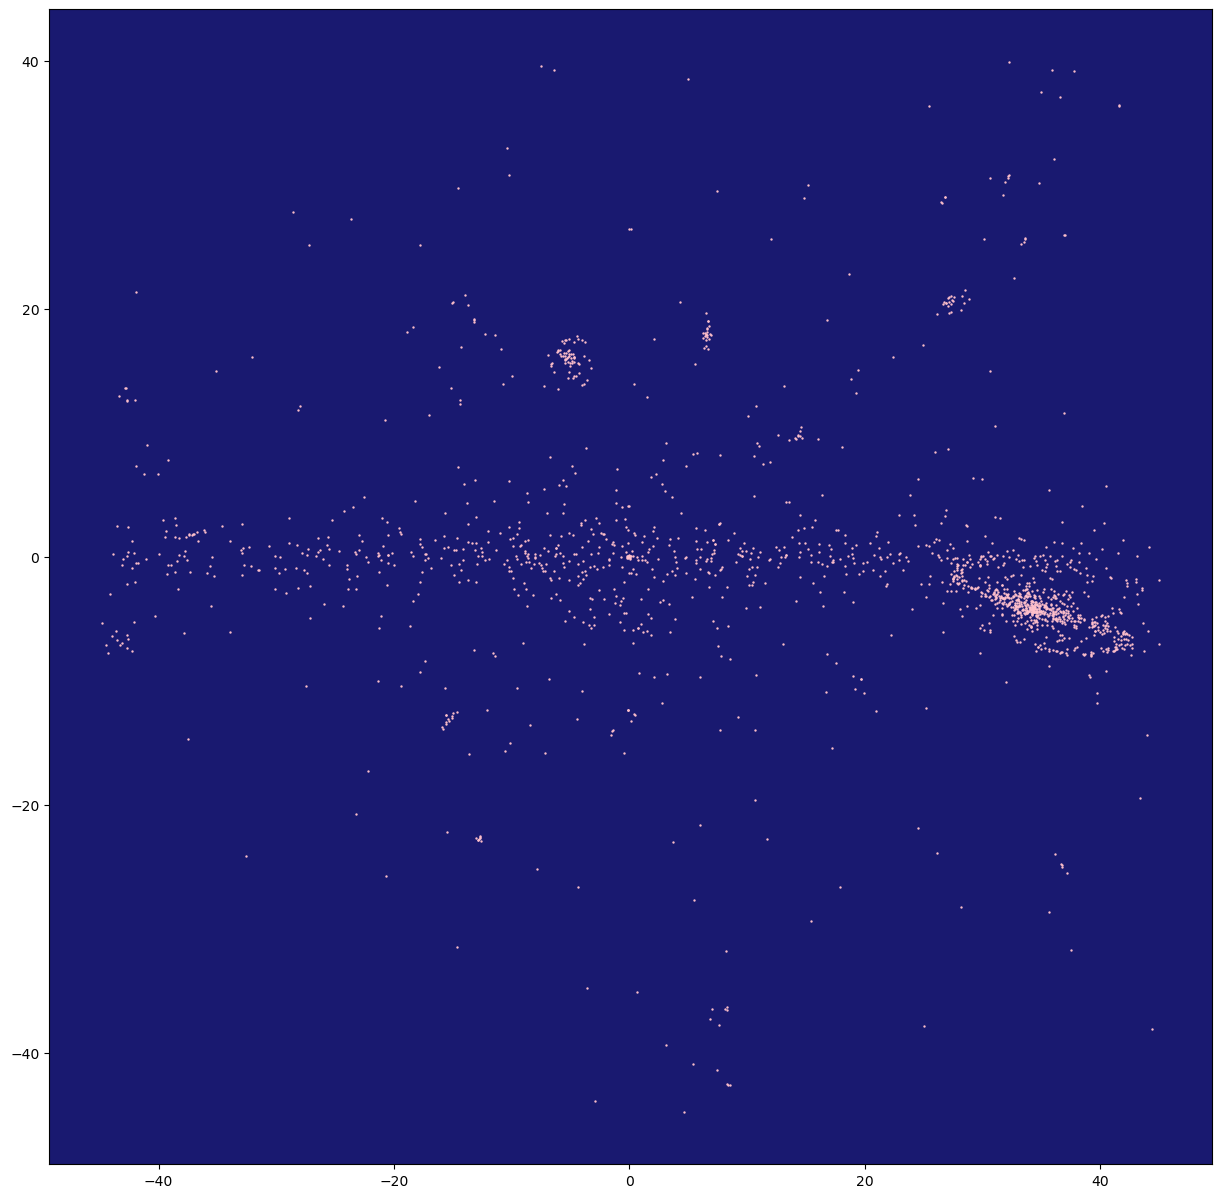

In [223]:
# take the index of the star iff it's above a certain parallax - try to get the far stars
star_index = [i for i, x in enumerate(parallax) if x > 0.001]

# find the X and Y pos of the respctive indexes of the far away stars
X_pos = [X_stars[i] for i in star_index]  
Y_pos = [Y_stars[i] for i in star_index]


# plot
fig = plt.figure(figsize=(15, 15))  
ax = fig.add_subplot(1, 1, 1)    
ax.scatter(X_pos, Y_pos, s=0.5, c='pink') 
ax.set_facecolor('midnightblue')

plt.show()  


In [224]:
import numpy as np  
from csv import DictWriter

parallax = np.array(parallax[star_index])
distance = (1 / parallax)
#dst_lbl = ["distance" for x in range(len(parallax))]

x_rad, y_rad = np.radians(X_pos), np.radians(Y_pos) 
x = distance * np.cos(x_rad) * np.sin(y_rad)
y = distance * np.sin(x_rad) * np.sin(y_rad)
z = distance * np.cos(y_rad)

#fig = plt.figure(figsize=(10, 10));  
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, z, s=0.5)
ax.set_xlabel('pc')
ax.set_ylabel('pc') 
ax.set_zlabel('pc')

df = pd.DataFrame(distance)
df.to_csv('distance.csv', index=False)
#dist = pd.DataFrame()
#print(dist)
#distance.to_csv('distance.csv', index=False)

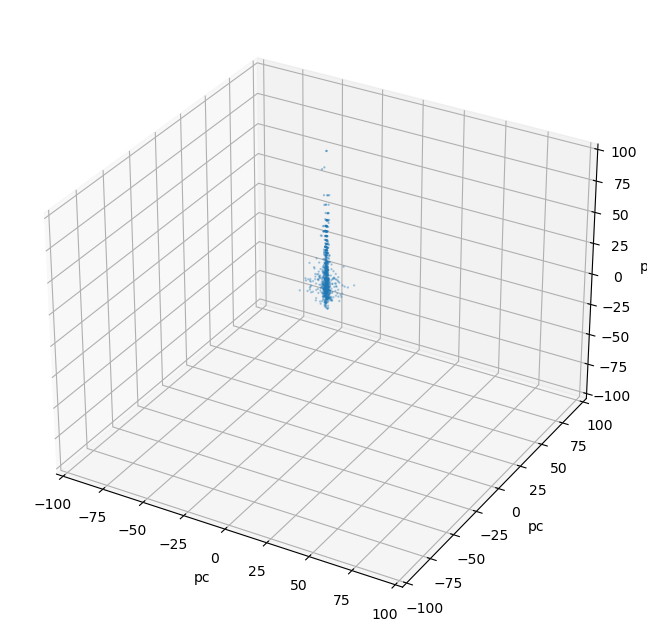

In [225]:


closeindexes =  [i for i, x in enumerate(parallax) if x > 0.001] # restriction step

closex = x[closeindexes]; closey = y[closeindexes]; closez = z[closeindexes]; # get the XYZ of close stars
fig = plt.figure(figsize=(8, 8));  # and now plot
ax = fig.add_subplot(projection='3d')
ax.scatter(closex, closey, closez, s=0.5); 
ax.set_xlabel('pc'); ax.set_ylabel('pc'); ax.set_zlabel('pc');
ax.set_xlim([-100, 100]); ax.set_ylim([-100, 100]); ax.set_zlim([-100, 100]); # we want some equal axis limits so things are proportional
plt.show()


In [226]:
variables = data["Variable?"]
variableindexes = [i for i, x in enumerate(parallax) if x > 0.001 and variables[i] == 1] 
starnames = data['Name']; starnames = [i for i in starnames]
variablenames = [starnames[i] for i in variableindexes]
variableparallaxes = np.array([data["Parallax"][i] for i in variableindexes])

Vfluxes = data['GreenF']; variableVfluxes = np.array([Vfluxes[i] for i in variableindexes])
variableVlumins = variableVfluxes * 4 * np.pi * ((1 / variableparallaxes) * 3.086 * 10**16)**2

C:\Users\neha\AppData\Local\Temp\ipykernel_32292\2691076772.py:8: RuntimeWarning: divide by zero encountered in divide
  variableVlumins = variableVfluxes * 4 * np.pi * ((1 / variableparallaxes) * 3.086 * 10**16)**2


In [227]:
from astropy.timeseries import LombScargle
from glob import glob


fnames = glob(ddir + "*/Star_Data.csv")
freqs = np.linspace(1/120, 0.45, 10000) # frequency grid shouldn't go higher than Nyquist limit

for lightcurve in fnames[-2:]:    # im only searching in reverse to avoid the first data point being noisy!
    if lightcurve[len(ddir):-4] in variablenames: # this checks whether the star of this lightcurve is in our variable stars
        data = pd.read_csv(lightcurve, delimiter=' ') # load in the data
        time, flux = data['Time'], data['NormalisedFlux'] # just extract the columns as variables
        plt.scatter(time, flux); 
        plt.title('Star lightcurve'); plt.xlabel('Hours'); plt.ylabel('Normalised Flux'); plt.show()
        LS = LombScargle(time, flux) # initialize a Lomb-Scargle
        power = LS.power(freqs) # calculate LS power 
        plt.plot(freqs, power); plt.xlabel('Frequency (1/hrs)')
        plt.ylabel('LS Power')
        plt.show()
        print('Most likely period: %.2f h' % (1 / freqs[np.argmax(power)]))
        break     

In [229]:
def monte_carlo(xdata, xuncs, ydata, yuncs, iterations):
    grads = np.zeros(iterations)
    yints = np.zeros(iterations)
    x_rand = np.zeros(len(xdata))
    y_rand = np.zeros(len(xdata))
    if np.size(xuncs) == 1:
        xuncs = np.ones(len(xdata)) * xuncs
    if np.size(yuncs) == 1:
        yuncs = np.ones(len(ydata)) * yuncs
    
    for i in range(iterations):
        for j in range(len(xdata)):
            x_rand[j] = np.random.normal(xdata[j], xuncs[j])
            y_rand[j] = np.random.normal(ydata[j], yuncs[j])
        grads[i], yints[i] = np.polyfit(x_rand, y_rand, 1)
    
    meangrad = np.mean(grads[:i])
    SDgrad = np.std(grads[:i])
    meanyint = np.mean(yints[:i])
    SDyint = np.std(yints[:i])
    return np.array([meangrad, SDgrad, meanyint, SDyint])